In [1]:
import numpy as np
import random
from qiskit import *
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from qiskit.circuit import Parameter
import random
%matplotlib inline

In [2]:
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub = 'ibm-q')

# num_qubits = 6

# from qiskit.providers.ibmq import least_busy
# possible_devices = provider.backends(filters=lambda x: 
#                                      x.configuration().n_qubits >= num_qubits
#                                        and 
#                                      x.configuration().simulator == False)
# qcomp = least_busy(possible_devices)

In [3]:
# import qiskit.tools.jupyter
# %qiskit_job_watcher

In [4]:
def reverse(string):
    str = ""
    for i in string:
        str = i + str
    return str

In [5]:
def mixer(beta,num_qubit):
    codeword = QuantumRegister(num_qubit,'codeword')
    
    recieved = QuantumRegister(num_qubit,'recieved')
    circ = QuantumCircuit(codeword,recieved)
    
    
    #circ.h(1)
  
    circ.rx(2*beta,1)

    #circ.h(1)

    
    circ.barrier()
    

    
    circ.barrier()
    return circ

In [6]:
def cost_unitary(gamma,num_qubit):
    codeword = QuantumRegister(num_qubit,'codeword')
    
    recieved = QuantumRegister(num_qubit,'recieved')
    
    circ = QuantumCircuit(codeword,recieved)
    for i in range(num_qubit):
        circ.cx(codeword[i],recieved[i])
        circ.rz((-gamma),recieved[i])
        circ.cx(codeword[i],recieved[i])
        circ.barrier()
    
    return circ

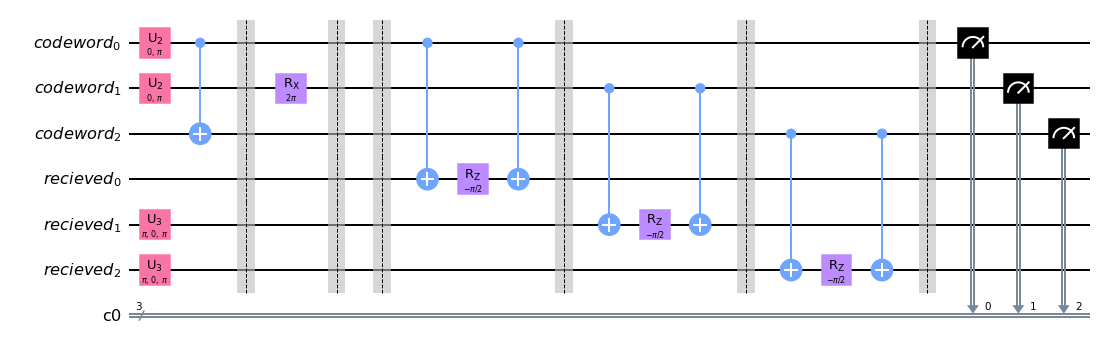

In [7]:
gamma = Parameter("$\\gamma$") 

beta = Parameter("$\\beta$")

def create_qaoa_circ(theta,num_qubit,p,r):
    
    beta = theta[0]
    gamma = theta[1]

    codeword = QuantumRegister(num_qubit,'codeword')
    recieved = QuantumRegister(num_qubit,'recieved')
    cbit = ClassicalRegister(num_qubit)
    circ = QuantumCircuit(codeword,recieved,cbit)

    # if the codeword recieved is r = |0010>, in qiskit the 1 is in the 1st position of recieved register.
    
    for i in range(len(r)):
        if r[i] == '1':
            circ.x(recieved[i])
    
    circ.h(range(2))
    
    circ.cx(0,2)
    
    circ.barrier()
    
    for i in range(p):
        
        circ.append(mixer(beta,num_qubit),range(2*num_qubit))
        circ.append(cost_unitary(gamma,num_qubit),range(2*num_qubit))

    circ.measure(range(num_qubit),range(num_qubit))
    
    #circ.measure_all()
    
    return circ


circ = create_qaoa_circ([np.pi,np.pi/2],3,1,'011')
circ.decompose().draw('mpl')

In [8]:
# define a function which calculate the function value for a measurement
def hamming_weight(x,r):
    
    weight = 0
    for i in range(len(r)):
        if x[i]!=r[i]:
            weight = weight + 1
    return weight

#print(hamming_weight('0110','1110'))

# define a function for calculating the average
def compute_expectation(counts,r):
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        obj = hamming_weight(reverse(bitstring),r)          # r is |0010>
        avg = avg + (obj*count)
        sum_count = sum_count + count
    
    expectn = avg/sum_count
        
    return expectn

def get_expectation(p,r):
    simulator = Aer.get_backend('qasm_simulator')
    #shots = 1000
    
    num_qubit = 3
    def execute_circ(theta):
#         num_qubits = 6

#         from qiskit.providers.ibmq import least_busy
#         possible_devices = provider.backends(filters=lambda x: 
#                                              x.configuration().n_qubits >= num_qubits
#                                                and 
#                                              x.configuration().simulator == False)
#         qcomp = least_busy(possible_devices)

        circ = create_qaoa_circ(theta,num_qubit,p,r)
        job = execute(circ, backend=simulator, shots=2000)
        counts = job.result().get_counts()
        
        return compute_expectation(counts, r)
    
    return execute_circ

In [9]:
from scipy.optimize import minimize

# def printx(Xi):
    
#     global Nfeval
#     print('At iterate {0:4d},  f={1: 3.6f} '.format(Nfeval, expectation(Xi)) + '\n')
   

#     Nfeval += 1
r = '011'
p = 3
f_max = 1.0
optm_param = []
data = []
param_beta = []
param_gamma = []

#for pp in range(p):
func = []
approx_ratio = []
param_1 = []
param_2 = []
for repeatation in range(5):
    
    expectation = get_expectation(p,r)
    
    Nfeval = 1
   

    res = minimize(expectation, 
                          [random.uniform(0,100*np.pi),random.uniform(0,200*np.pi)],      # [1.0,np.pi]
                          method = 'COBYLA')#, callback=printx) 
   
    func.append(res.fun)
    param_1.append(res.x[0])
    param_2.append(res.x[1])
for i in range(len(func)):
    approx_ratio.append(func[i]/f_max)
min_approx_ratio = min(approx_ratio)

for i in range(len(func)):
    if approx_ratio[i] == min_approx_ratio:
        param_beta.append(param_1[i])
        param_gamma.append(param_2[i])
   
#     data.append(min_approx_ratio)
#     print('At each p = '+str(pp+1)+' the minimum approximation ratio is :',min_approx_ratio)

In [10]:
for i in range(len(func)):
    approx_ratio.append(func[i]/f_max)
min_approx_ratio = min(approx_ratio)

for i in range(len(func)):
    if approx_ratio[i] == min_approx_ratio:
        param_beta.append(param_1[i])
        param_gamma.append(param_2[i])

In [11]:
num_qubit = 3

ip = [param_beta[0],param_gamma[0]]
optm_circ = create_qaoa_circ(ip,num_qubit,p,r)

simulator = Aer.get_backend('qasm_simulator')
job = execute(optm_circ, backend=simulator, shots=2000)
counts = job.result().get_counts()
plt.tight_layout()
plot_histogram(counts,color='blue',title='Quantum Viterbi [3,2,1] & p = '+str(p)+' & r = '+str(r)).savefig('321.png',dpi=300)


<Figure size 432x288 with 0 Axes>

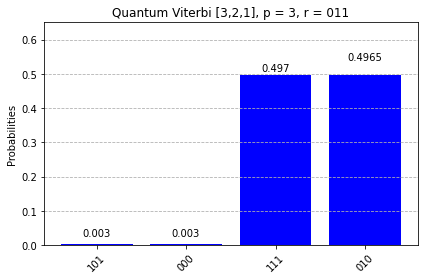

In [12]:
data_x = list(counts.keys())
data_y = list(counts.values())
data_x.reverse()
data_y.reverse()
y = []

for i in range(len(data_y)):
    y.append(data_y[i]/2000)
    
plt.bar(data_x,y,color = 'blue')
plt.ylim(0,0.65)
plt.title('Quantum Viterbi [3,2,1], p = '+str(p)+', r = '+str(r))
plt.ylabel('Probabilities')


plt.text(2.8,0.54,y[len(data_y)-1])
plt.text(1.84,0.5085,y[len(data_y)-2])
plt.text(0.84,0.0265,y[len(data_y)-3])
plt.text(-0.16,0.0265,y[len(data_y)-3])
# plt.text(3.5,0.4,y[3])

plt.xticks(data_x,data_x,rotation = 45)
plt.grid(linestyle = '--',axis='y')
plt.tight_layout()
plt.savefig('321upo2_600.png',dpi=600)

In [13]:
print(func)

[1.227, 1.2385, 1.007, 1.3655, 1.214]


In [14]:
optm_circ.depth()

9